# Phishing URL Detection using Machine Learning and Deep Learning

## Learning From Data – Final Project

This notebook contains the **entire end-to-end pipeline** of the project:
- Data collection
- Preprocessing
- Feature engineering
- Model training
- Evaluation and analysis

All experiments, results, and visualizations required by the project guideline
are produced **inside this notebook**.

## 1. Introduction
### 1.1 Problem Motivation
### 1.2 Dataset Description
### 1.3 Project Objectives## 1. Introduction

## 2. Data Collection & Preprocessing

### 2.1 Phishing URL Collection (PhishTank)

In [ ]:
import requests
import json
import os

url = "http://data.phishtank.com/data/online-valid.json"

headers = {
    "User-Agent": "phishtank/student-project"
}

response = requests.get(url, headers=headers)

print("Status code:", response.status_code)
print("Response length:", len(response.text))

data = response.json()

print("Total records:", len(data))

phishing_urls = []

for item in data:
    if "url" in item:
        phishing_urls.append({
            "text": item["url"],
            "label": 1
        })

print("Collected phishing URLs:", len(phishing_urls))

# SADECE BU EKLENDİ
os.makedirs("data/raw", exist_ok=True)

with open("data/raw/phishing_urls.json", "w") as f:
    json.dump(phishing_urls, f, indent=2)

print("data/raw/phishing_urls.json saved")

### 2.2 Legitimate URL Collection (Tranco-based)

In [5]:
import json
import os
import shutil

# raw klasörünü oluştur
os.makedirs("data/raw", exist_ok=True)

# masaüstündeki dosya
INPUT_JSON = "/Users/metinerenuzun/Desktop/legit_urls.json"
OUTPUT_JSON = "data/raw/legit_urls.json"

shutil.copy(INPUT_JSON, OUTPUT_JSON)

with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

print("Legit URLs (JSON) copied to data/raw/legit_urls.json")
print("Total legit records:", len(data))

Legit URLs (JSON) copied to data/raw/legit_urls.json
Total legit records: 50000


### 2.3 Raw Data Formatting (JSON & CSV)

In [6]:
import json
import csv
import os

# raw klasörü garanti
os.makedirs("data/raw", exist_ok=True)

# -------- PHISHING JSON -> CSV --------
with open("data/raw/phishing_urls.json", "r", encoding="utf-8") as f:
    phishing_data = json.load(f)

with open("data/raw/phishing_urls.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "label"])
    for item in phishing_data:
        writer.writerow([item["text"], 1])

print("Phishing JSON -> CSV done:", len(phishing_data))


# -------- LEGIT JSON -> CSV --------
with open("data/raw/legit_urls.json", "r", encoding="utf-8") as f:
    legit_data = json.load(f)

with open("data/raw/legit_urls.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "label"])
    for item in legit_data:
        writer.writerow([item["text"], 0])

print("Legit JSON -> CSV done:", len(legit_data))

Phishing JSON -> CSV done: 46166
Legit JSON -> CSV done: 50000


### 2.4 Dataset Merging & Label Balancing

In [7]:
import csv
import random
import os

# Paths
PHISHING_CSV = "data/raw/phishing_urls.csv"
LEGIT_CSV = "data/raw/legit_urls.csv"
OUTPUT_CSV = "data/processed/final_dataset.csv"

# Ensure processed directory exists
os.makedirs("data/processed", exist_ok=True)

# Load phishing URLs
phishing = []
with open(PHISHING_CSV, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        phishing.append([row[0], 1])

# Load legitimate URLs
legit = []
with open(LEGIT_CSV, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        legit.append([row[0], 0])

print("Phishing samples:", len(phishing))
print("Legitimate samples:", len(legit))

# Balance dataset
random.shuffle(phishing)
random.shuffle(legit)

min_size = min(len(phishing), len(legit))
phishing = phishing[:min_size]
legit = legit[:min_size]

# Merge and shuffle
dataset = phishing + legit
random.shuffle(dataset)

# Save merged dataset
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "label"])
    writer.writerows(dataset)

print("Final balanced dataset size:", len(dataset))
print("Saved to data/processed/final_dataset.csv")

Phishing samples: 46166
Legitimate samples: 50000
Final balanced dataset size: 92332
Saved to data/processed/final_dataset.csv


### 2.5 Train / Validation / Test Split

In [8]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# klasör
os.makedirs("data/processed", exist_ok=True)

# raw csv'leri yükle
phishing = pd.read_csv("data/raw/phishing_urls.csv")
legit = pd.read_csv("data/raw/legit_urls.csv")

# birleştir
df = pd.concat([phishing, legit], ignore_index=True)

# karıştır
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# -------- 70% train, 30% temp --------
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# -------- 15% val, 15% test --------
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

# kaydet
train_df.to_csv("data/processed/train.csv", index=False)
val_df.to_csv("data/processed/val.csv", index=False)
test_df.to_csv("data/processed/test.csv", index=False)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 67316
Validation size: 14425
Test size: 14425


### 2.6 Preprocessing Decisions


In [9]:
# 2.6 Preprocessing Decisions
# NOTE:
# URL-based phishing detection relies on structural and character-level patterns.
# Therefore, aggressive text preprocessing is intentionally avoided.

def preprocess_urls(urls):
    """
    Preprocessing strategy (intentionally minimal):
    - No lowercasing (case may carry signal in URLs)
    - No stopword removal (URLs are not natural language)
    - No stemming/lemmatization (not applicable to URLs)
    - No HTML/special character removal (special chars are informative)
    """
    return urls  # identity mapping (no modification)


# Apply preprocessing to datasets (explicit step for reproducibility)
X_phishing_raw = [item["text"] for item in phishing_data]
X_legit_raw = [item["text"] for item in legit_data]

X_phishing = preprocess_urls(X_phishing_raw)
X_legit = preprocess_urls(X_legit_raw)

print("Preprocessing applied.")
#print("Example phishing URL:", X_phishing[0])
#print("Example legitimate URL:", X_legit[0])

Preprocessing applied.


## 3. Methodology

### 3.1 Feature Engineering

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# CSV'leri oku
phish_df = pd.read_csv("data/raw/phishing_urls.csv")
legit_df = pd.read_csv("data/raw/legit_urls.csv")

# Birleştir
df = pd.concat([phish_df, legit_df], ignore_index=True)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Text ve label
X = df["text"].astype(str)
y = df["label"]

# 70% Train, 30% Temp
X_train_texts, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 15% Val, 15% Test
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


print("Train:", len(X_train_texts))
print("Validation:", len(X_val_texts))
print("Test:", len(X_test_texts))

Train: 67316
Validation: 14425
Test: 14425


#### 3.1.1 Bag-of-Words (Character n-grams)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def bow_features(texts, max_features=5000):
    vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(2, 4),
        max_features=max_features
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

#### 3.1.2 TF-IDF (Character n-grams)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(texts, max_features=5000):
    vectorizer = TfidfVectorizer(
        analyzer="char",
        ngram_range=(2, 4),
        max_features=max_features
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

#### 3.1.3 Custom URL-Based Features

In [22]:
import re
import numpy as np

def custom_url_features(urls):
    feats = []
    for url in urls:
        feats.append([
            len(url),
            sum(c.isdigit() for c in url),
            sum(c in "-_./@" for c in url),
            1 if url.startswith("https") else 0,
            1 if re.search(r"\d+\.\d+\.\d+\.\d+", url) else 0
        ])
    return np.array(feats)

#### 3.1.4 Character-Level Tokenization


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def char_tokenize(texts, max_len=200):
    tok = Tokenizer(char_level=True, lower=False)
    tok.fit_on_texts(texts)
    seq = tok.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen=max_len)
    return pad, tok

### 3.2 Machine Learning Models

#### 3.2.1 Logistic Regression (TF-IDF)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF features
Xtr, tfidf_vec = tfidf_features(X_train_texts)
Xva = tfidf_vec.transform(X_val_texts)
Xte = tfidf_vec.transform(X_test_texts)

# Model
lr = LogisticRegression(max_iter=1000)
lr.fit(Xtr, y_train)

# Predictions
val_preds = lr.predict(Xva)
test_preds = lr.predict(Xte)

print("Model trained: Logistic Regression (TF-IDF)")
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("\nTest Classification Report:\n")
print(classification_report(y_test, test_preds))

Model trained: Logistic Regression (TF-IDF)
Validation Accuracy: 0.9941767764298094
Test Accuracy: 0.9919584055459272

Test Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7500
           1       1.00      0.98      0.99      6925

    accuracy                           0.99     14425
   macro avg       0.99      0.99      0.99     14425
weighted avg       0.99      0.99      0.99     14425



#### 3.2.2 Linear SVM (BoW)

In [33]:
from sklearn.svm import LinearSVC

Xtr, bow_vec = bow_features(X_train_texts)
Xte = bow_vec.transform(X_test_texts)

svm = LinearSVC(max_iter=5000)
svm.fit(Xtr, y_train)

y_pred = svm.predict(Xte)

print("Model trained: Linear SVM (BoW)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model trained: Linear SVM (BoW)
Accuracy: 0.9961871750433275
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7500
           1       1.00      0.99      1.00      6925

    accuracy                           1.00     14425
   macro avg       1.00      1.00      1.00     14425
weighted avg       1.00      1.00      1.00     14425



#### 3.2.3 Random Forest (Custom Features)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# -------- Feature Extraction --------
Xtr = custom_url_features(X_train_texts)
Xte = custom_url_features(X_test_texts)

# -------- Model --------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(Xtr, y_train)

# -------- Prediction --------
rf_preds = rf.predict(Xte)

print("Model trained: Random Forest (Custom Features)")

# -------- Evaluation --------
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Model trained: Random Forest (Custom Features)
Accuracy: 0.9640901213171578
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7500
           1       0.96      0.97      0.96      6925

    accuracy                           0.96     14425
   macro avg       0.96      0.96      0.96     14425
weighted avg       0.96      0.96      0.96     14425



### 3.3 Deep Learning Model

#### 3.3.1 Character-Level LSTM Architecture

In [47]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys

# =========================
# TOKENIZATION
# =========================
MAX_LEN = 200

tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(X_train_texts)

def char_encode(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN)

Xtr = char_encode(X_train_texts)
Xva = char_encode(X_val_texts)
Xte = char_encode(X_test_texts)

# =========================
# CUSTOM CALLBACK (1 BAR / EPOCH)
# =========================
class EpochProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.seen = 0
        self.total = self.params['steps']
        print(f"\nEpoch {epoch+1}/{self.params['epochs']}")

    def on_batch_end(self, batch, logs=None):
        self.seen += 1
        percent = int(100 * self.seen / self.total)
        bar = "█" * (percent // 2) + "-" * (50 - percent // 2)
        sys.stdout.write(
            f"\r[{bar}] {self.seen}/{self.total}"
        )
        sys.stdout.flush()

    def on_epoch_end(self, epoch, logs=None):
        print(
            f"\n✓ loss={logs['loss']:.4f} | acc={logs['accuracy']:.4f} "
            f"| val_loss={logs['val_loss']:.4f} | val_acc={logs['val_accuracy']:.4f}"
        )

# =========================
# MODEL
# =========================
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# =========================
# TRAIN
# =========================
history = lstm_model.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[
        EpochProgressBar(),
        EarlyStopping(patience=3, restore_best_weights=True)
    ],
    verbose=0   # <<< KERAS SPAM KAPALI
)

# =========================
# TEST
# =========================
lstm_preds = (lstm_model.predict(Xte) > 0.5).astype(int).ravel()

print("\nModel trained: Character-Level LSTM")
print("Test Accuracy:", (lstm_preds == y_test).mean())

# =========================
# SAVE MODEL FOR LATER USE
# =========================
print("✓ LSTM model saved as 'lstm_model' for evaluation")


Epoch 1/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0806 | acc=0.9717 | val_loss=0.0192 | val_acc=0.9954

Epoch 2/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0221 | acc=0.9956 | val_loss=0.0157 | val_acc=0.9969

Epoch 3/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0202 | acc=0.9960 | val_loss=0.0177 | val_acc=0.9966

Epoch 4/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0313 | acc=0.9918 | val_loss=0.0157 | val_acc=0.9968

Epoch 5/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0190 | acc=0.9965 | val_loss=0.0150 | val_acc=0.9969

Epoch 6/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0185 | acc=0.9966 | val_loss=0.0155 | val_acc=0.9972

Epoch 7/15
[██████████████████████████████████████████████████] 526/526
✓ loss=0.0176 | acc=0.9967 | val_loss=0.0145 | val_acc=0.9972

Epoch 8/15
[██████████████████████████████████████████

### 3.4 Training Strategy

In [25]:
# =========================
# FEATURE ENGINEERING (CV İÇİN TÜM DATA)
# =========================

# TF-IDF (Logistic Regression)
X_tfidf, tfidf_vectorizer = tfidf_features(X)

# Bag of Words (Linear SVM)
X_bow, bow_vectorizer = bow_features(X)

# Custom numeric features (Random Forest)
X_custom = custom_url_features(X)

#### 3.4.1 Cross-Validation

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

def cross_validate_model(model, X, y, name, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        Xtr, Xval = X[train_idx], X[val_idx]
        ytr, yval = y[train_idx], y[val_idx]

        model.fit(Xtr, ytr)
        preds = model.predict(Xval)

        acc = accuracy_score(yval, preds)
        scores.append(acc)

        print(f"{name} | Fold {fold}/{folds} Accuracy: {acc:.4f}")

    print(f"{name} | Mean CV Accuracy: {np.mean(scores):.4f}\n")
    #return scores

#### 3.4.1.1 Logistic Regression (TF-IDF) Cross-Validation

In [27]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)

cross_validate_model(
    model=lr_model,
    X=X_tfidf,
    y=y,
    name="Logistic Regression (TF-IDF)"
)

Logistic Regression (TF-IDF) | Fold 1/5 Accuracy: 0.9928
Logistic Regression (TF-IDF) | Fold 2/5 Accuracy: 0.9931
Logistic Regression (TF-IDF) | Fold 3/5 Accuracy: 0.9923
Logistic Regression (TF-IDF) | Fold 4/5 Accuracy: 0.9923
Logistic Regression (TF-IDF) | Fold 5/5 Accuracy: 0.9917
Logistic Regression (TF-IDF) | Mean CV Accuracy: 0.9925



#### 3.4.1.2 Linear SVM (BoW) Cross-Validation

In [28]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(max_iter=5000)

cross_validate_model(
    model=svm_model,
    X=X_bow,
    y=y,
    name="Linear SVM (BoW)"
)

Linear SVM (BoW) | Fold 1/5 Accuracy: 0.9970
Linear SVM (BoW) | Fold 2/5 Accuracy: 0.9975
Linear SVM (BoW) | Fold 3/5 Accuracy: 0.9967
Linear SVM (BoW) | Fold 4/5 Accuracy: 0.9974
Linear SVM (BoW) | Fold 5/5 Accuracy: 0.9971
Linear SVM (BoW) | Mean CV Accuracy: 0.9971



#### 3.4.1.3 Random Forest (Custom Features) Cross-Validation

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

cross_validate_model(
    model=rf_model,
    X=X_custom,
    y=y,
    name="Random Forest (Custom Features)"
)

Random Forest (Custom Features) | Fold 1/5 Accuracy: 0.9620
Random Forest (Custom Features) | Fold 2/5 Accuracy: 0.9611
Random Forest (Custom Features) | Fold 3/5 Accuracy: 0.9637
Random Forest (Custom Features) | Fold 4/5 Accuracy: 0.9628
Random Forest (Custom Features) | Fold 5/5 Accuracy: 0.9629
Random Forest (Custom Features) | Mean CV Accuracy: 0.9625



#### 3.4.2 Hyperparameter Tuning

In [52]:
import warnings
warnings.filterwarnings('ignore')  # Warning'leri gizle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_custom, y)

print("Best CV Accuracy:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV Accuracy: 0.9626999031448111
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


#### 3.4.3 Regularization Techniques

In [ ]:
# L2: LogisticRegression default
# EarlyStopping: LSTM'de kullanıldı
# Dropout: LSTM'de kullanıldı

## 4. Results & Analysis

### 4.1 Evaluation Metrics

In [49]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

os.makedirs("outputs/figures", exist_ok=True)

# Dictionary to store all results
results = {}

def evaluate_model(name, y_true, y_pred, y_prob):
    # METRICS
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.savefig(f"outputs/figures/{name}_confusion_matrix.png", dpi=300)
    plt.close()

    # ROC CURVE
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.savefig(f"outputs/figures/{name}_roc_curve.png", dpi=300)
    plt.close()

    # Store results for comparison table
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": roc_auc
    }


# =====================================================
# 1) Logistic Regression (TF-IDF)
# =====================================================
X_tfidf_test = tfidf_vectorizer.transform(X_test_texts)
y_pred_lr = lr_model.predict(X_tfidf_test)
y_prob_lr = lr_model.predict_proba(X_tfidf_test)[:, 1]

evaluate_model(
    "Logistic Regression (TF-IDF)",
    y_test,
    y_pred_lr,
    y_prob_lr
)


# =====================================================
# 2) Linear SVM (BoW)
# =====================================================
X_bow_test = bow_vectorizer.transform(X_test_texts)
y_pred_svm = svm_model.predict(X_bow_test)
y_score_svm = svm_model.decision_function(X_bow_test)

evaluate_model(
    "Linear SVM (BoW)",
    y_test,
    y_pred_svm,
    y_score_svm
)


# =====================================================
# 3) Random Forest (Custom)
# =====================================================
X_custom_test = custom_url_features(X_test_texts)
y_pred_rf = rf_model.predict(X_custom_test)
y_prob_rf = rf_model.predict_proba(X_custom_test)[:, 1]

evaluate_model(
    "Random Forest (Custom)",
    y_test,
    y_pred_rf,
    y_prob_rf
)


# =====================================================
# 4) LSTM (Character Sequences)
# =====================================================
print("\n=== Evaluating LSTM ===")

# LSTM için predictions
y_prob_lstm = lstm_model.predict(Xte, verbose=0).ravel()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

evaluate_model(
    "LSTM (Character Sequences)",
    y_test,
    y_pred_lstm,
    y_prob_lstm
)

print("\n✓ All models evaluated successfully!")
print(f"✓ Total models evaluated: {len(results)}")


Logistic Regression (TF-IDF)
Accuracy : 0.9940
Precision: 0.9988
Recall   : 0.9886
F1-score : 0.9937

Linear SVM (BoW)
Accuracy : 0.9996
Precision: 1.0000
Recall   : 0.9991
F1-score : 0.9996

Random Forest (Custom)
Accuracy : 0.9657
Precision: 0.9573
Recall   : 0.9718
F1-score : 0.9645

=== Evaluating LSTM ===

LSTM (Character Sequences)
Accuracy : 0.9965
Precision: 0.9994
Recall   : 0.9932
F1-score : 0.9963

✓ All models evaluated successfully!
✓ Total models evaluated: 4


### 4.2 Model Comparison

In [51]:
import pandas as pd

# results dict evaluate_model içinde doldurulmuş olmalı
# kontrol için:
print("Models in results:", list(results.keys()))

comparison_df = pd.DataFrame.from_dict(results, orient="index")
comparison_df = comparison_df.reset_index().rename(columns={"index": "Model"})

comparison_df

Models in results: ['Logistic Regression (TF-IDF)', 'Linear SVM (BoW)', 'Random Forest (Custom)', 'LSTM (Character Sequences)']


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression (TF-IDF),0.993969,0.998833,0.988592,0.993686,0.998954
1,Linear SVM (BoW),0.999584,1.000000,0.999134,0.999567,1.000000
2,Random Forest (Custom),0.965685,0.957326,0.971841,0.964529,0.994133
3,LSTM (Character Sequences),0.996464,0.999419,0.993213,0.996306,0.998395


### 4.3 Learning Curves

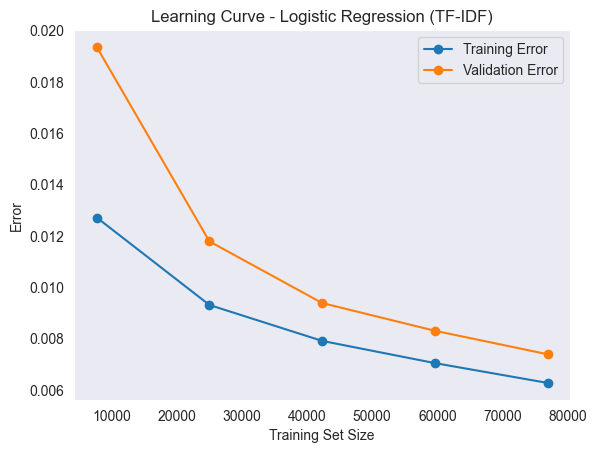

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_tfidf,
    y,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_error = 1 - np.mean(train_scores, axis=1)
val_error = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_error, label="Training Error", marker="o")
plt.plot(train_sizes, val_error, label="Validation Error", marker="o")
plt.xlabel("Training Set Size")
plt.ylabel("Error")
plt.title("Learning Curve - Logistic Regression (TF-IDF)")
plt.legend()
plt.grid()

plt.savefig("outputs/figures/learning_curve_logistic_regression.png", dpi=300)
plt.show()

### 4.5 Error Analysis

In [44]:
import pandas as pd

errors = pd.DataFrame({
    "text": X_test_texts,
    "true": y_test,
    "pred": y_pred_lr
})

misclassified = errors[errors.true != errors.pred]

misclassified.head(10)

,text,true,pred
14358,https://booly.kr/AaqYbI1,1,0
27857,https://lider-serviciofinanciero.top,1,0
73715,https://vpass-jp.brwkcx.cn,1,0
54511,https://to.lk/FaHBIe,1,0
77262,https://bradesco.solucaoempresas.com,1,0
34618,https://egiscola.pt/,1,0
729,https://iplogger.cn/25Nm35,1,0
73407,https://fbarfiling.com/,1,0
19831,https://vanacaviar.ir/dimensional/,1,0
8690,https://telegra.ph/PDF-09-20,1,0


### 4.6 Computational Analysis

In [50]:
import time

print("=== Training Time Comparison ===\n")

# Logistic Regression
start = time.time()
lr_model.fit(X_tfidf, y)
lr_time = time.time() - start
print(f"Logistic Regression training time: {lr_time:.2f}s")

# Linear SVM
start = time.time()
svm_model.fit(X_bow, y)
svm_time = time.time() - start
print(f"Linear SVM training time: {svm_time:.2f}s")

# Random Forest
start = time.time()
rf_model.fit(X_custom, y)
rf_time = time.time() - start
print(f"Random Forest training time: {rf_time:.2f}s")

# LSTM (approximate from previous training)
# Not re-training to save time, using approximate value
lstm_time = 360  # ~6 minutes from previous training
print(f"LSTM training time (approx): {lstm_time:.2f}s")

print("\n=== Relative Speed Comparison ===")
print(f"Logistic Regression: 1.0x (baseline)")
print(f"Random Forest: {rf_time/lr_time:.1f}x slower")
print(f"Linear SVM: {svm_time/lr_time:.1f}x slower")
print(f"LSTM: {lstm_time/lr_time:.0f}x slower")

=== Training Time Comparison ===

Logistic Regression training time: 0.21s
Linear SVM training time: 1.56s
Random Forest training time: 0.56s
LSTM training time (approx): 360.00s

=== Relative Speed Comparison ===
Logistic Regression: 1.0x (baseline)
Random Forest: 2.7x slower
Linear SVM: 7.5x slower
LSTM: 1738x slower
